In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("davidvazquezcic/yawn-dataset")

# print("Path to dataset files:", path)

In [2]:
import os
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
import torch
import matplotlib.pyplot as plt
import numpy as np
import splitfolders
from tqdm.notebook import trange, tqdm

In [4]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'  # Fixes OpenMP error on Windows

dataset_path = r'C:\Users\leoki\.cache\kagglehub\datasets\davidvazquezcic\yawn-dataset\versions\1'

output_folder = os.path.join(dataset_path, 'split')

splitfolders.ratio(dataset_path, output=output_folder, seed=42, ratio=(0.7, 0.15, 0.15), group_prefix=None, move=False)

Copying files: 5119 files [00:04, 1216.78 files/s]


In [5]:
# Data Preparation
data_transform = {
        'train' : transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.8, 1.2)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        'val' : transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),
        'test': transforms.Compose([
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
    }

phases = ['train', 'val', 'test']

image_dataset = {x: datasets.ImageFolder(os.path.join(output_folder, x), data_transform[x]) for x in phases}
dataloaders = {x: torch.utils.data.DataLoader(image_dataset[x], batch_size=64, shuffle=True, num_workers=4) for x in phases}

class_names = image_dataset['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"Classes: {class_names}")

Using device: cuda:0
Classes: ['no yawn', 'yawn']


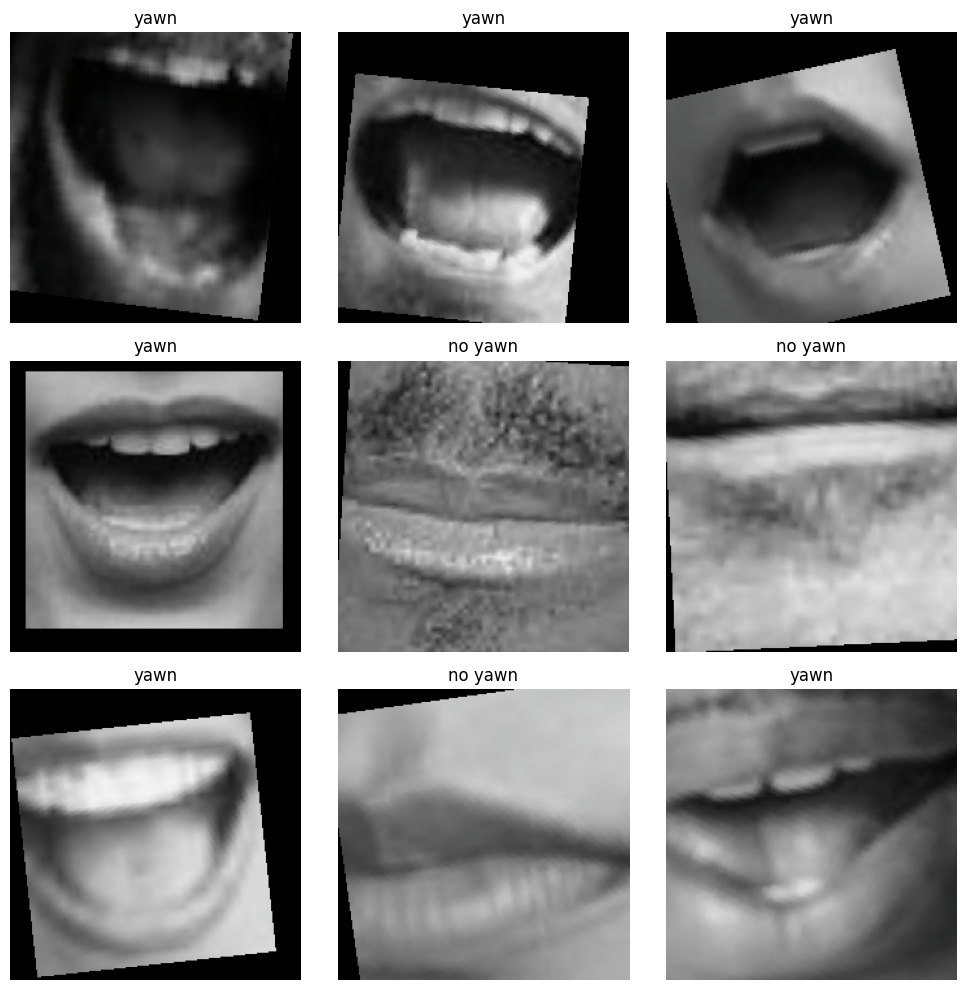

In [6]:
# Data Visualization
inputs, classes = next(iter(dataloaders['train']))

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

for i in range(9):
    ax = axes.flat[i]
    img = inputs[i]

    # Unormalize the image
    img = img.numpy().transpose((1, 2, 0)) * std + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)
    ax.set_title(class_names[classes[i]])
    ax.axis('off')

plt.tight_layout()
plt.show()

In [15]:
# Model Definition
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
for param in model.parameters():
    param.requires_grad = False  # Freeze all layers

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))  # Adjust final layer for our classes

model = model.to(device)

In [16]:
# Training

optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
epochs = 15

epoch_pbar = trange(epochs, desc="Overall Progress")

for epoch in epoch_pbar:
    epoch_metrics = {}
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        running_loss = 0.0
        running_corrects = 0
        
        phase_pbar = tqdm(dataloaders[phase], desc=f"{phase.capitalize()} Progress", leave=False)

        for inputs, labels in phase_pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(image_dataset[phase])
        epoch_acc = running_corrects.double() / len(image_dataset[phase])

        epoch_metrics[f'{phase}_loss'] = f"{epoch_loss:.4f}"
        epoch_metrics[f'{phase}_acc'] = f"{epoch_acc:.4f}"
    
    epoch_pbar.set_postfix(epoch_metrics)

model_path = 'yawnnet_model.pth'
torch.save(model.state_dict(), model_path)  # Save the final model state

Overall Progress:   0%|          | 0/15 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

Train Progress:   0%|          | 0/56 [00:00<?, ?it/s]

Val Progress:   0%|          | 0/12 [00:00<?, ?it/s]

In [18]:
# Test Model
model.load_state_dict(torch.load(model_path))
model.eval()

running_corrects = 0

with torch.no_grad():
    for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        running_corrects += torch.sum(preds == labels.data)
    
test_acc = running_corrects.double() / len(image_dataset['test'])
print(f"Test Accuracy: {test_acc:.4f}")



Test Accuracy: 0.9104
